# Data analyses of grouped data based on behaviour
In this notebook we are going to focus on analysing dataset, relationships between different features and especially the differences between stations in different clusters.

In [1]:
import pandas as pd
import numpy as np

## Load data

In [2]:
data = pd.read_csv('./datasets/data_beh_group.csv', sep=',')
data.head()

/tmp/ipykernel_92090/3752208142.py:1: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('./datasets/data_beh_group.csv', sep=',')


,gid,available,free,total,w_temp,w_sky,w_precip,w_humid,w_wind_speed,w_clouds,...,day_category,day_motive,lat,long,datetime,occupancy,vacancy,bikes_diff,free_diff,cluster
0,901622,18,2,20,12.0,Cielo cubierto,0.0,66.0,6.8,88.0,...,Working day,NaN,39.458781,-0.358658,2022-12-01 02:00:00,0.900000,0.100000,0.0,0.0,3
1,901673,9,29,38,12.0,Cielo cubierto,0.0,66.0,6.8,88.0,...,Working day,NaN,39.472282,-0.343809,2022-12-01 02:00:00,0.236842,0.763158,0.0,0.0,1
2,901677,15,8,23,12.0,Cielo cubierto,0.0,66.0,6.8,88.0,...,Working day,NaN,39.473068,-0.343132,2022-12-01 02:00:00,0.652174,0.347826,0.0,0.0,3
3,901679,3,18,21,12.0,Cielo cubierto,0.0,66.0,6.8,88.0,...,Working day,NaN,39.471344,-0.340484,2022-12-01 02:00:00,0.142857,0.857143,0.0,0.0,3
4,901627,15,4,20,12.0,Cielo cubierto,0.0,66.0,6.8,88.0,...,Working day,NaN,39.456512,-0.355418,2022-12-01 02:00:00,0.750000,0.200000,0.0,0.0,3


In [3]:
k_clusters = data.cluster.nunique()
print(f'Number of clusters: {k_clusters}')

Number of clusters: 6


In [4]:
import math
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

def plot_colortable(colors, *, ncols=1):
    cell_width = 212
    cell_height = 22
    swatch_width = 48
    margin = 12

    n = len(colors)
    nrows = math.ceil(n / ncols)

    width = cell_width * ncols + 2 * margin
    height = cell_height * nrows + 2 * margin
    dpi = 72

    fig, ax = plt.subplots(figsize=(width / dpi, height / dpi), dpi=dpi)
    fig.subplots_adjust(margin/width, margin/height,
                        (width-margin)/width, (height-margin)/height)
    ax.set_xlim(0, cell_width * ncols)
    ax.set_ylim(cell_height * (nrows-0.5), -cell_height/2.)
    ax.yaxis.set_visible(False)
    ax.xaxis.set_visible(False)
    ax.set_axis_off()

    for i, name in enumerate(colors):
        row = i % nrows
        col = i // nrows
        y = row * cell_height

        swatch_start_x = cell_width * col
        text_pos_x = cell_width * col + swatch_width + 7

        ax.text(text_pos_x, y, f'Cluster {i}', fontsize=14,
                horizontalalignment='left',
                verticalalignment='center')

        ax.add_patch(
            Rectangle(xy=(swatch_start_x, y-9), width=swatch_width,
                      height=18, facecolor=colors[name], edgecolor='0.7')
        )

    return fig


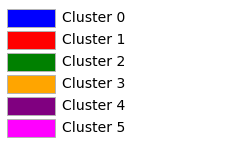

In [5]:
colors = {'blue': 'blue', 'red': 'red', 'green': 'green', 'orange': 'orange', 'purple': 'purple', 'magenta': 'magenta'}

plot_colortable(colors)

plt.show()

In [6]:
cluster_color = list(colors.keys())

## Retype features

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10891319 entries, 0 to 10891318
Data columns (total 22 columns):
 #   Column        Dtype  
---  ------        -----  
 0   gid           int64  
 1   available     int64  
 2   free          int64  
 3   total         int64  
 4   w_temp        float64
 5   w_sky         object 
 6   w_precip      float64
 7   w_humid       float64
 8   w_wind_speed  float64
 9   w_clouds      float64
 10  w_visib       float64
 11  dayofweek     object 
 12  day_category  object 
 13  day_motive    object 
 14  lat           float64
 15  long          float64
 16  datetime      object 
 17  occupancy     float64
 18  vacancy       float64
 19  bikes_diff    float64
 20  free_diff     float64
 21  cluster       int64  
dtypes: float64(12), int64(5), object(5)
memory usage: 1.8+ GB


In [8]:
data['datetime'] = pd.to_datetime(data['datetime'])

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10891319 entries, 0 to 10891318
Data columns (total 22 columns):
 #   Column        Dtype         
---  ------        -----         
 0   gid           int64         
 1   available     int64         
 2   free          int64         
 3   total         int64         
 4   w_temp        float64       
 5   w_sky         object        
 6   w_precip      float64       
 7   w_humid       float64       
 8   w_wind_speed  float64       
 9   w_clouds      float64       
 10  w_visib       float64       
 11  dayofweek     object        
 12  day_category  object        
 13  day_motive    object        
 14  lat           float64       
 15  long          float64       
 16  datetime      datetime64[ns]
 17  occupancy     float64       
 18  vacancy       float64       
 19  bikes_diff    float64       
 20  free_diff     float64       
 21  cluster       int64         
dtypes: datetime64[ns](1), float64(12), int64(5), object(4)
memory us

## Plot stations on map

In [10]:
locations = data[["gid", "lat", "long"]].drop_duplicates()
print(locations.head())

if len(locations) != locations.gid.unique().shape[0]:
    print("some stations has multiple locations")

      gid        lat      long
0  901622  39.458781 -0.358658
1  901673  39.472282 -0.343809
2  901677  39.473068 -0.343132
3  901679  39.471344 -0.340484
4  901627  39.456512 -0.355418


In [11]:
import folium

# array of all the stations in the network
stations = data.gid.unique()

# extracting information about each station's total number of available racks
stations_size = data.groupby(["gid"])["total"].mean()

f = folium.Figure(width=700, height=700)
map = folium.Map(location=[39.4502730411, -0.333362], tiles='OpenStreetMap', zoom_start=12)

for station in stations:
    folium.Circle(
        location=[data[data.gid == station]['lat'].iloc[0], data[data.gid == station]['long'].iloc[0]],
        color=cluster_color[data[data.gid == station]['cluster'].iloc[0]],
        radius=5 * stations_size.loc[station],
        fill=True,
        opacity=0.8,
        fill_opacity=0.2,
        tooltip='Station {} | Docks: {} | Cluster: {}'.format(
            station, stations_size.loc[station], data[data.gid == station]['cluster'].iloc[0])
    ).add_to(map)

f.add_child(map)


## How the situation change over time
Here we will analyze the occupancy, vacancy and usage of stations and how it depends on the time of day or year.

### Change over hours

In [12]:
# Group data by hour and calculate average occupancy
hourly_avg_occupancy = data.groupby(data['datetime'].dt.hour)['occupancy'].mean()
hourly_avg_occupancy *= 100
hourly_avg_occupancy

datetime
0     44.174370
1     44.694445
2     45.072520
3     45.261961
4     45.356451
5     45.402263
6     45.157068
7     44.309410
8     42.187970
9     41.268110
10    41.197421
11    40.834252
12    40.564972
13    40.522869
14    40.400524
15    40.953531
16    41.399028
17    41.178564
18    41.068401
19    41.215029
20    41.780395
21    42.710640
22    43.614513
23    43.996775
Name: occupancy, dtype: float64

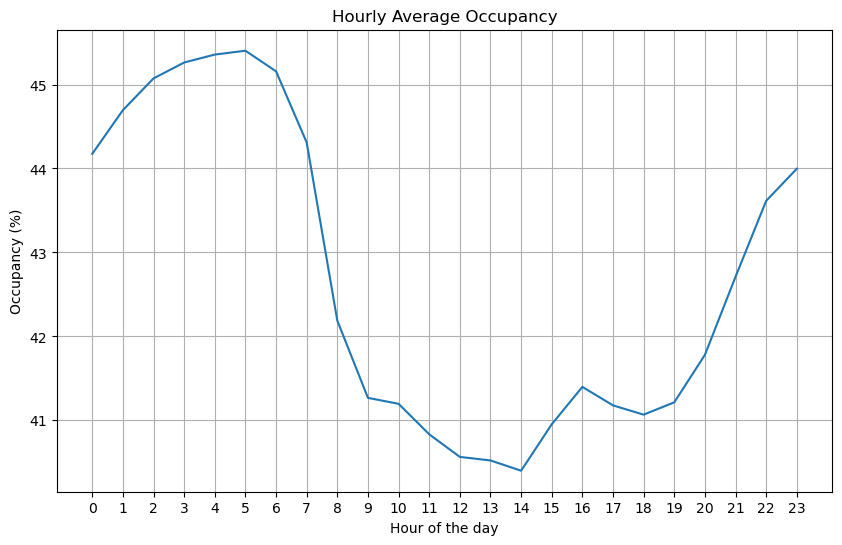

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(hourly_avg_occupancy.index, hourly_avg_occupancy.values)
plt.title('Hourly Average Occupancy')
plt.xlabel('Hour of the day')
plt.ylabel('Occupancy (%)')
plt.xticks(range(24))
plt.grid(True)
plt.show()

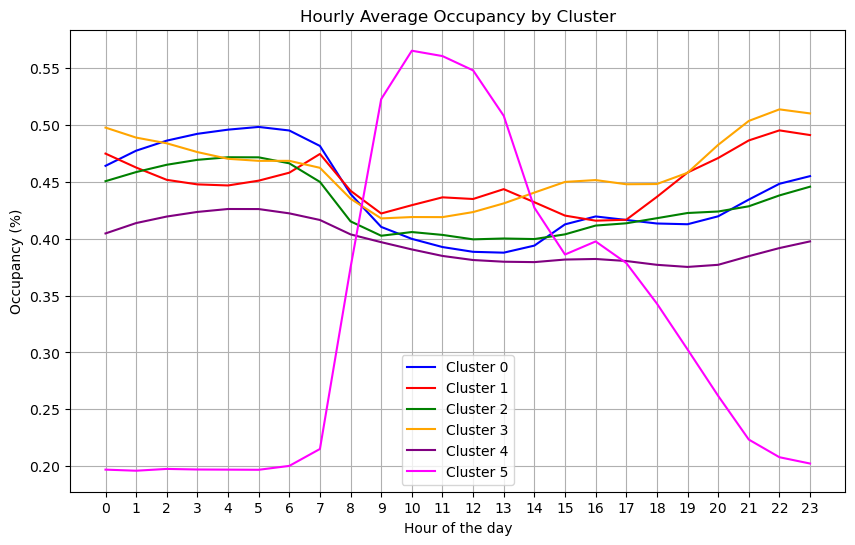

In [14]:
# Grouping by cluster and hour to calculate hourly average occupancy for each cluster
hourly_avg_occupancy_per_cluster = data.groupby(['cluster', data['datetime'].dt.hour])['occupancy'].mean()

plt.figure(figsize=(10, 6))
for cluster in range(k_clusters):
    cluster_data = hourly_avg_occupancy_per_cluster[cluster]
    plt.plot(cluster_data.index, cluster_data.values, label=f'Cluster {cluster}', color=cluster_color[cluster])

plt.title('Hourly Average Occupancy by Cluster')
plt.xlabel('Hour of the day')
plt.ylabel('Occupancy (%)')
plt.xticks(range(24))
plt.grid(True)
plt.legend()
plt.show()

In [15]:
hourly_avg_vacancy = data.groupby(data['datetime'].dt.hour)['vacancy'].mean()
hourly_avg_vacancy *= 100
hourly_avg_vacancy

datetime
0     54.278170
1     53.759589
2     53.374941
3     53.185279
4     53.094693
5     53.045026
6     53.264552
7     54.067473
8     56.159478
9     57.092871
10    57.139768
11    57.489584
12    57.801317
13    57.927304
14    58.055682
15    57.490607
16    57.055283
17    57.276250
18    57.386224
19    57.255205
20    56.708530
21    55.769415
22    54.856164
23    54.467844
Name: vacancy, dtype: float64

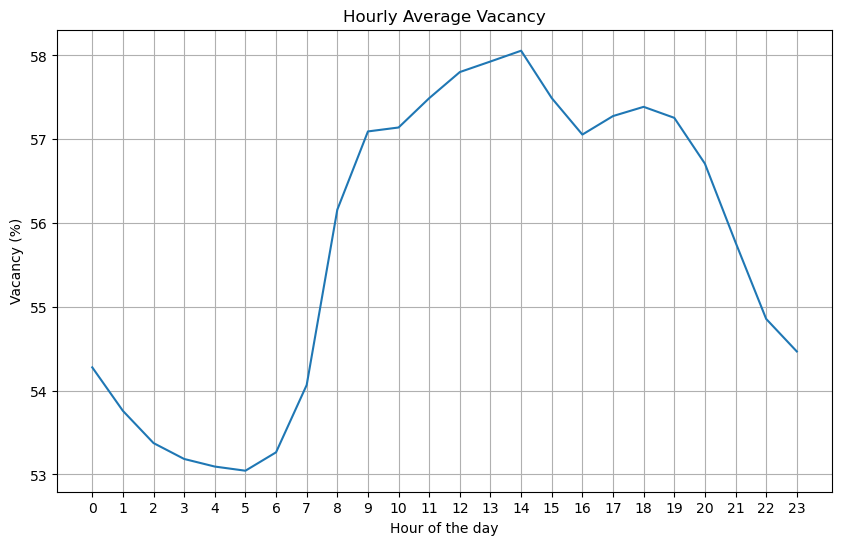

In [16]:
plt.figure(figsize=(10, 6))
plt.plot(hourly_avg_vacancy.index, hourly_avg_vacancy.values)
plt.title('Hourly Average Vacancy')
plt.xlabel('Hour of the day')
plt.ylabel('Vacancy (%)')
plt.xticks(range(24))
plt.grid(True)
plt.show()

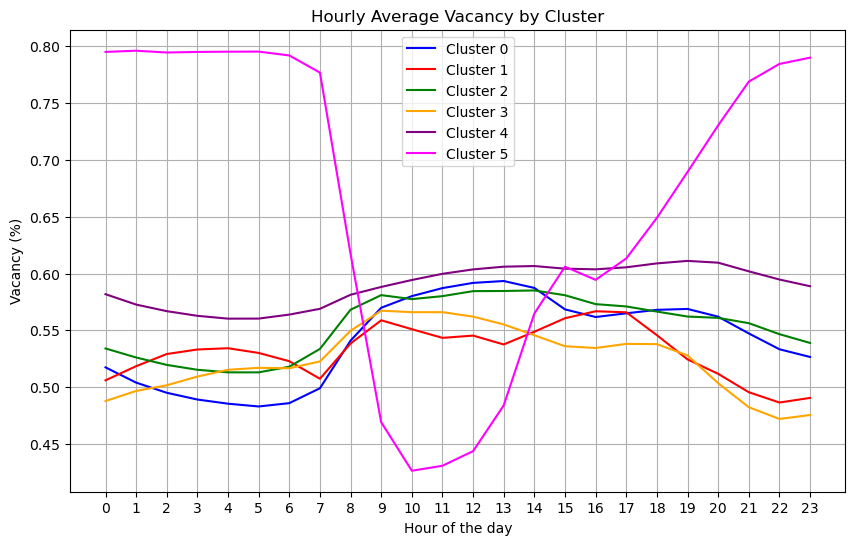

In [17]:
# Grouping by cluster and hour to calculate hourly average vacancy for each cluster
hourly_avg_vacancy_per_cluster = data.groupby(['cluster', data['datetime'].dt.hour])['vacancy'].mean()

# Plotting all clusters on the same graph with different colors
plt.figure(figsize=(10, 6))
for cluster in range(k_clusters):
    cluster_data = hourly_avg_vacancy_per_cluster.loc[cluster]
    plt.plot(cluster_data.index, cluster_data.values, label=f'Cluster {cluster}', color=cluster_color[cluster])

plt.title('Hourly Average Vacancy by Cluster')
plt.xlabel('Hour of the day')
plt.ylabel('Vacancy (%)')
plt.xticks(range(24))
plt.grid(True)
plt.legend()
plt.show()

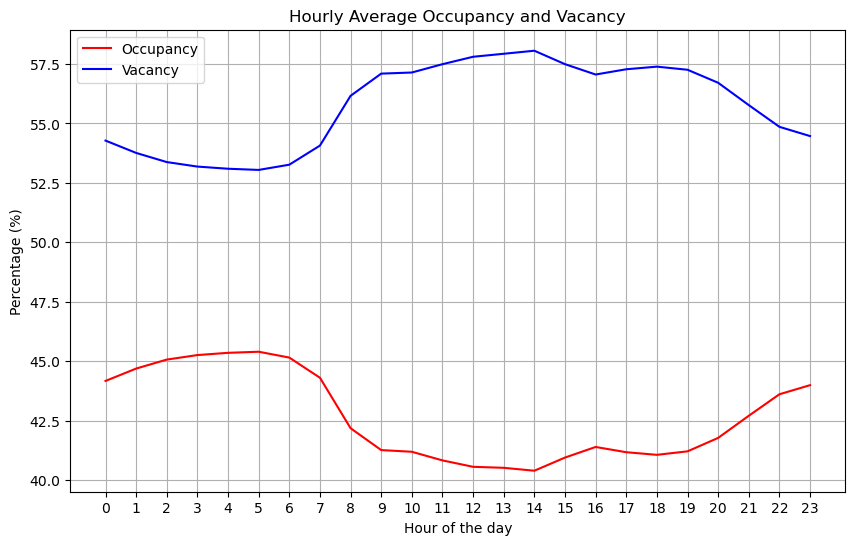

In [18]:
plt.figure(figsize=(10, 6))

# Plot hourly average occupancy with red color
plt.plot(hourly_avg_occupancy.index, hourly_avg_occupancy.values, color='red', label='Occupancy')

# Plot hourly average vacancy with blue color
plt.plot(hourly_avg_vacancy.index, hourly_avg_vacancy.values, color='blue', label='Vacancy')

plt.title('Hourly Average Occupancy and Vacancy')
plt.xlabel('Hour of the day')
plt.ylabel('Percentage (%)')
plt.xticks(range(24))
plt.grid(True)
plt.legend()
plt.show()

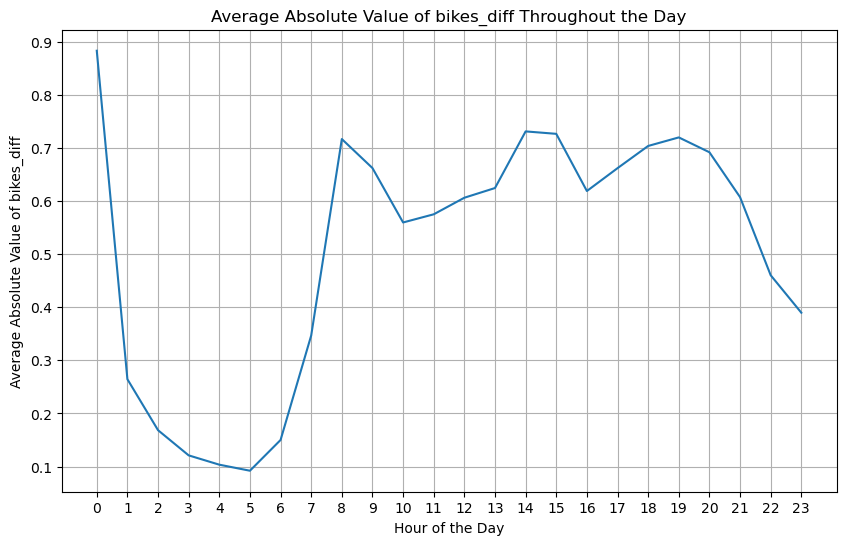

In [19]:
# Group by hour of the day and calculate the average absolute value of bikes_diff
hourly_avg_abs_bikes_diff = data.groupby(data.datetime.dt.hour)['bikes_diff'].apply(lambda x: np.mean(np.abs(x)))

# Plotting the average absolute value of bikes_diff throughout the day
plt.figure(figsize=(10, 6))
plt.plot(hourly_avg_abs_bikes_diff.index, hourly_avg_abs_bikes_diff.values)
plt.title('Average Absolute Value of bikes_diff Throughout the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Absolute Value of bikes_diff')
plt.xticks(range(24))
plt.grid(True)
plt.show()

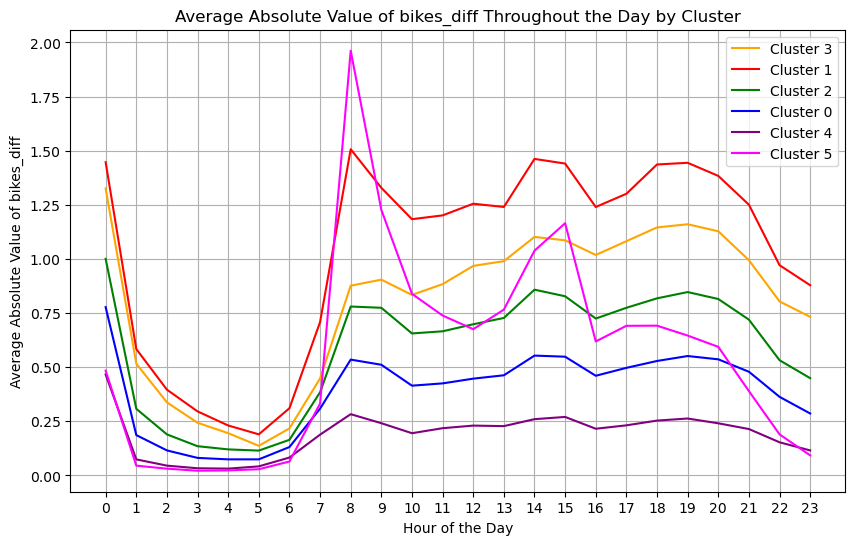

In [20]:
# Get unique cluster values
clusters = data['cluster'].unique()

# Plotting for each cluster
plt.figure(figsize=(10, 6))
for cluster in clusters:
    # Filter data for the current cluster
    cluster_data = data[data['cluster'] == cluster]
    
    # Group by hour of the day and calculate the average absolute value of bikes_diff
    hourly_avg_abs_bikes_diff = cluster_data.groupby(cluster_data.datetime.dt.hour)['bikes_diff'].apply(lambda x: np.mean(np.abs(x)))
    
    # Plotting the average absolute value of bikes_diff throughout the day for the current cluster
    plt.plot(hourly_avg_abs_bikes_diff.index, hourly_avg_abs_bikes_diff.values, label=f'Cluster {cluster}', color=cluster_color[cluster])

plt.title('Average Absolute Value of bikes_diff Throughout the Day by Cluster')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Absolute Value of bikes_diff')
plt.xticks(range(24))
plt.grid(True)
plt.legend()
plt.show()


### Change over months

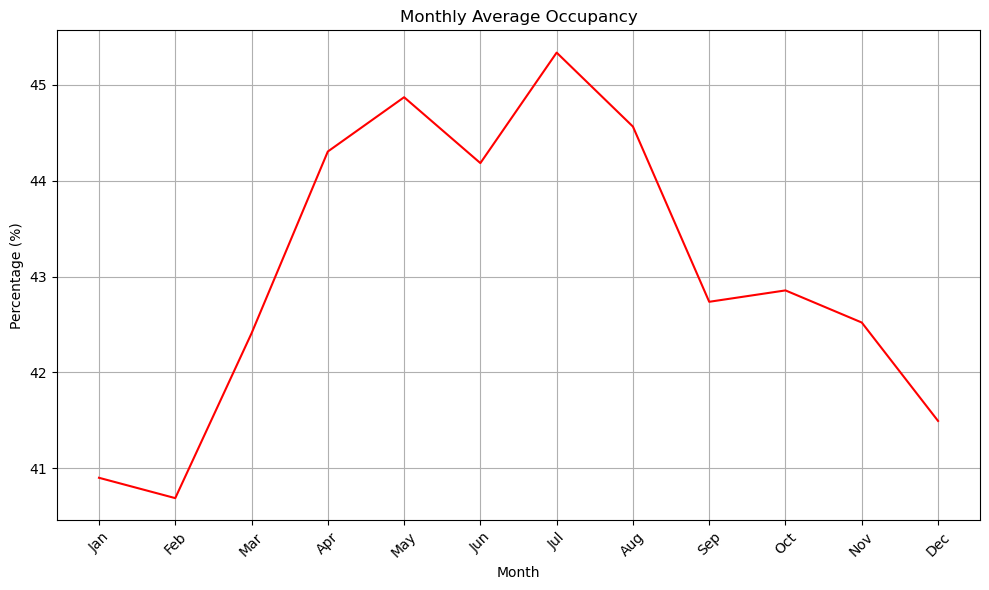

In [21]:
# Group data by month and calculate average occupancy
monthly_avg_occupancy = data.groupby([data['datetime'].dt.month])['occupancy'].mean() * 100

# Group data by month and calculate average vacancy
monthly_avg_vacancy = data.groupby([data['datetime'].dt.month])['vacancy'].mean() * 100

# Extract indices and values
indices = monthly_avg_occupancy.index
values = monthly_avg_occupancy.values

# Plotting
plt.figure(figsize=(10, 6))

# Plot monthly average occupancy with red color
plt.plot(range(len(indices)), values, color='red', linestyle='-')

plt.title('Monthly Average Occupancy')
plt.xlabel('Month')
plt.ylabel('Percentage (%)')
plt.xticks(range(len(indices)), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                                 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

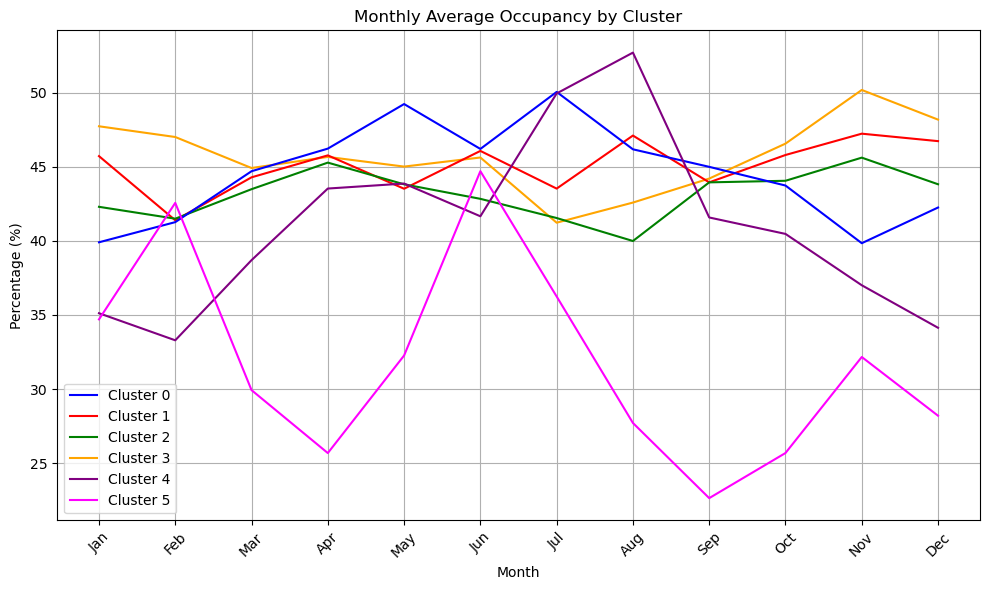

In [22]:
# Group data by cluster, year, and month and calculate average occupancy for each cluster
monthly_avg_occupancy_per_cluster = data.groupby(['cluster', data['datetime'].dt.month])['occupancy'].mean() * 100

# Extract unique clusters
clusters = data['cluster'].unique()

# Plotting all clusters on the same graph with different colors
plt.figure(figsize=(10, 6))

handles = []
labels = []

for cluster in clusters:
    cluster_data = monthly_avg_occupancy_per_cluster.loc[cluster]
    indices = cluster_data.index
    values = cluster_data.values
    line, = plt.plot(range(len(indices)), values, linestyle='-', label=f'Cluster {cluster}', color=cluster_color[cluster])
    handles.append(line)
    labels.append(f'Cluster {cluster}')

# Sorting legend handles and labels alphabetically
handles, labels = zip(*sorted(zip(handles, labels), key=lambda x: x[1]))

plt.title('Monthly Average Occupancy by Cluster')
plt.xlabel('Month')
plt.ylabel('Percentage (%)')
plt.xticks(range(len(indices)), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                                 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=45)
plt.grid(True)
plt.tight_layout()

# Displaying sorted legend
plt.legend(handles, labels)
plt.show()

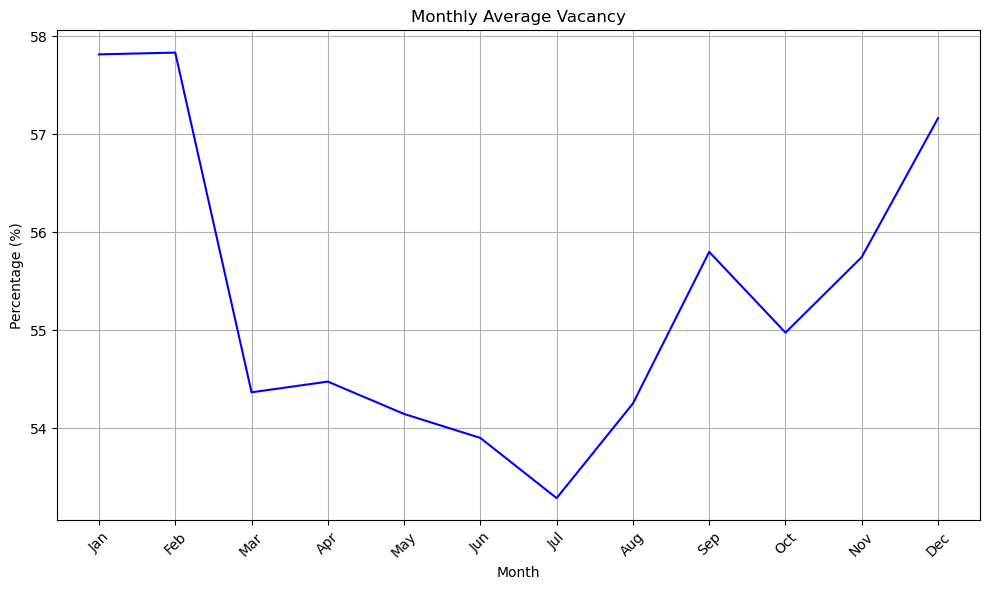

In [23]:
# Group data by month and calculate average vacancy
monthly_avg_vacancy = data.groupby([data['datetime'].dt.month])['vacancy'].mean() * 100

# Extract indices and values
indices = monthly_avg_vacancy.index
values = monthly_avg_vacancy.values

# Plotting
plt.figure(figsize=(10, 6))

# Plot monthly average vacancy with blue color
plt.plot(range(len(indices)), values, color='blue', linestyle='-')

plt.title('Monthly Average Vacancy')
plt.xlabel('Month')
plt.ylabel('Percentage (%)')
plt.xticks(range(len(indices)), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                                 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

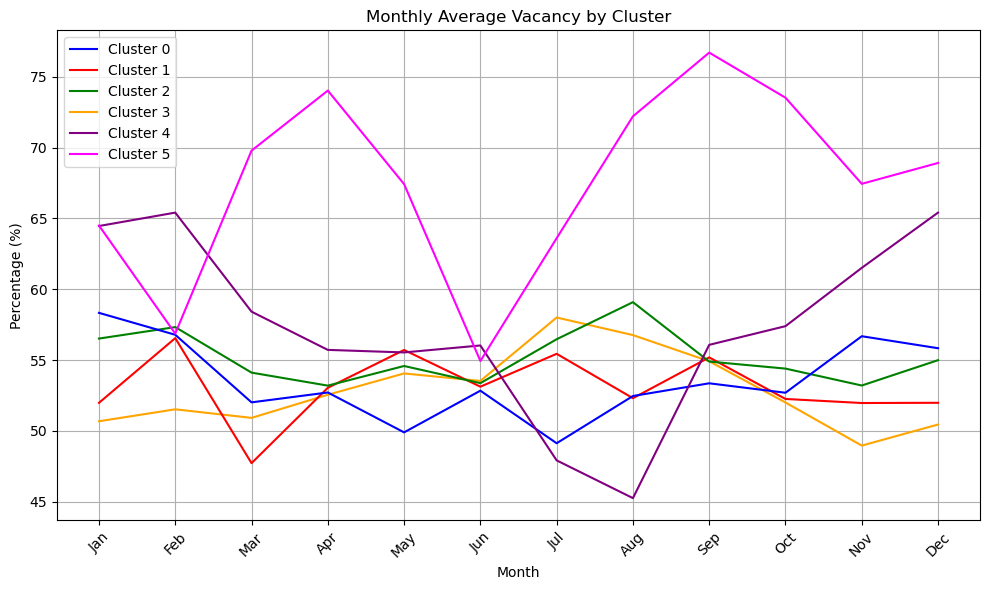

In [24]:
# Group data by cluster, year, and month and calculate average vacancy for each cluster
monthly_avg_vacancy_per_cluster = data.groupby(['cluster', data['datetime'].dt.month])['vacancy'].mean() * 100

# Extract unique clusters
clusters = data['cluster'].unique()

# Plotting all clusters on the same graph with different colors
plt.figure(figsize=(10, 6))

handles = []
labels = []

for cluster in clusters:
    cluster_data = monthly_avg_vacancy_per_cluster.loc[cluster]
    indices = cluster_data.index
    values = cluster_data.values
    line, = plt.plot(range(len(indices)), values, linestyle='-', label=f'Cluster {cluster}', color=cluster_color[cluster])
    handles.append(line)
    labels.append(f'Cluster {cluster}')

# Sorting legend handles and labels alphabetically
handles, labels = zip(*sorted(zip(handles, labels), key=lambda x: x[1]))

plt.title('Monthly Average Vacancy by Cluster')
plt.xlabel('Month')
plt.ylabel('Percentage (%)')
plt.xticks(range(len(indices)), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                                 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=45)
plt.grid(True)
plt.tight_layout()

# Displaying sorted legend
plt.legend(handles, labels)
plt.show()

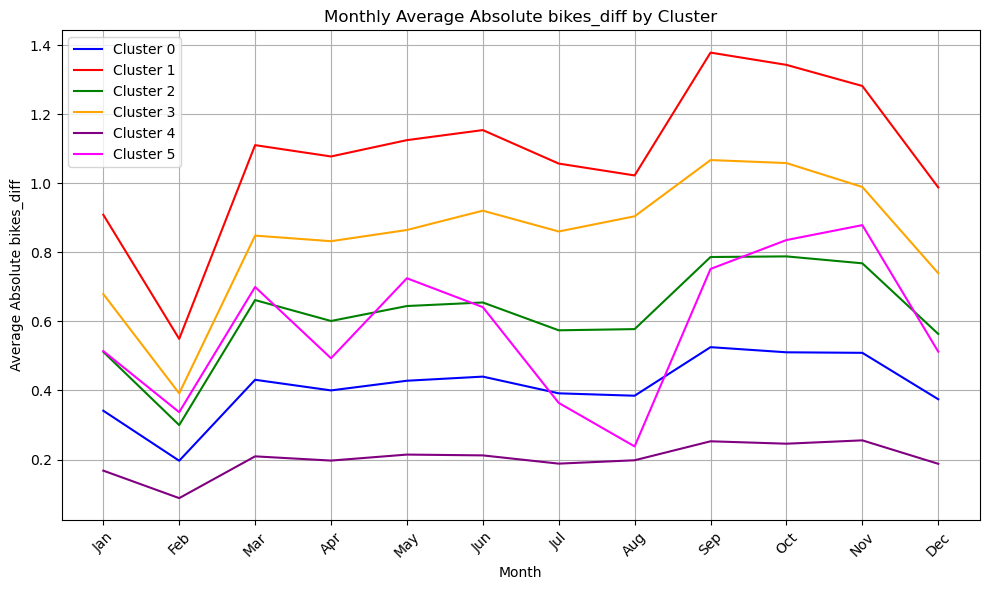

In [25]:
# Group data by cluster, year, and month and calculate average absolute bikes_diff for each cluster
monthly_avg_abs_bikes_diff_per_cluster = data.groupby(['cluster', data['datetime'].dt.month])['bikes_diff'].apply(lambda x: np.mean(np.abs(x)))

# Extract unique clusters
clusters = data['cluster'].unique()

# Plotting all clusters on the same graph with different colors
plt.figure(figsize=(10, 6))

handles = []
labels = []

for cluster in clusters:
    cluster_data = monthly_avg_abs_bikes_diff_per_cluster.loc[cluster]
    indices = cluster_data.index
    values = cluster_data.values
    line, = plt.plot(range(len(indices)), values, linestyle='-', label=f'Cluster {cluster}', color=cluster_color[cluster])
    handles.append(line)
    labels.append(f'Cluster {cluster}')

# Sorting legend handles and labels alphabetically
handles, labels = zip(*sorted(zip(handles, labels), key=lambda x: x[1]))

plt.title('Monthly Average Absolute bikes_diff by Cluster')
plt.xlabel('Month')
plt.ylabel('Average Absolute bikes_diff')
plt.xticks(range(len(indices)), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                                 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=45)
plt.grid(True)
plt.tight_layout()

# Displaying sorted legend
plt.legend(handles, labels)
plt.show()


## Add weather

Another interesting approach is to analyze the occupancy, vacancy and usage of stations dependencies on weather conditions.

### Temp

/tmp/ipykernel_92090/961567498.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_vacancy_per_cluster_temp_bin = data.groupby(['cluster', 'temp_bin'])['vacancy'].mean()


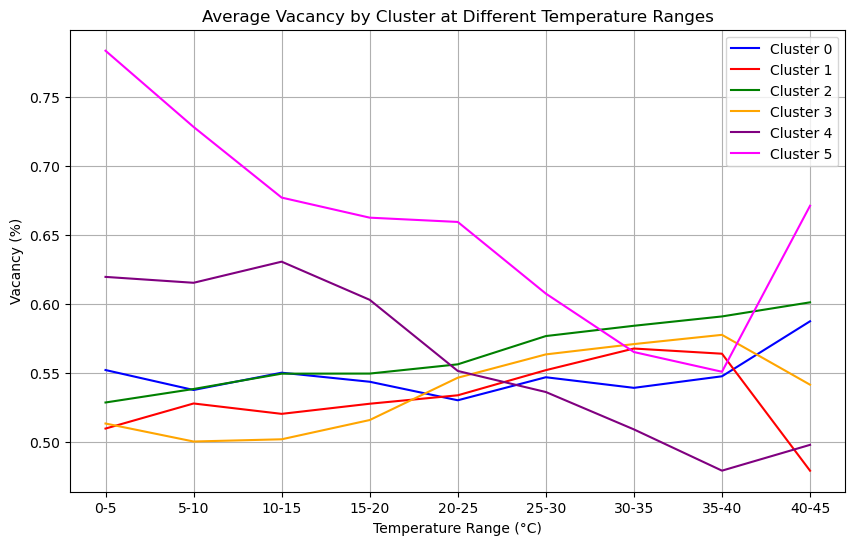

In [26]:
# Define temperature bins
temperature_bins = [-5, 0, 5, 10, 15, 20, 25, 30, 35, 40, 45]
temperature_labels = ['<=0', '0-5', '5-10', '10-15', '15-20', '20-25', '25-30', '30-35', '35-40', '40-45']

# Bin temperature data
data['temp_bin'] = pd.cut(data['w_temp'], bins=temperature_bins, labels=temperature_labels)

# Group by cluster and temperature bin to calculate average vacancy for each cluster
avg_vacancy_per_cluster_temp_bin = data.groupby(['cluster', 'temp_bin'])['vacancy'].mean()

# Plotting all clusters on the same graph with different colors
plt.figure(figsize=(10, 6))
for cluster in range(k_clusters):
    cluster_data = avg_vacancy_per_cluster_temp_bin.loc[cluster]
    plt.plot(cluster_data.index.get_level_values('temp_bin'), cluster_data.values, label=f'Cluster {cluster}', color=cluster_color[cluster])

plt.title('Average Vacancy by Cluster at Different Temperature Ranges')
plt.xlabel('Temperature Range (°C)')
plt.ylabel('Vacancy (%)')
plt.grid(True)
plt.legend()
plt.show()


/tmp/ipykernel_92090/2017983283.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_occupancy_per_cluster_temp_bin = data.groupby(['cluster', 'temp_bin'])['occupancy'].mean()


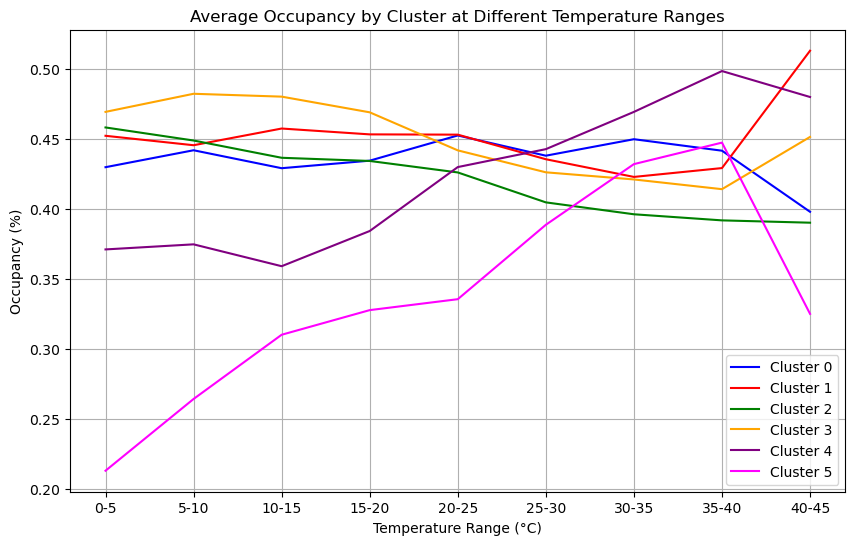

In [27]:
# Group by cluster and temperature bin to calculate average occupancy for each cluster
avg_occupancy_per_cluster_temp_bin = data.groupby(['cluster', 'temp_bin'])['occupancy'].mean()

# Plotting all clusters on the same graph with different colors
plt.figure(figsize=(10, 6))
for cluster in range(k_clusters):
    cluster_data = avg_occupancy_per_cluster_temp_bin.loc[cluster]
    plt.plot(cluster_data.index.get_level_values('temp_bin'), cluster_data.values, label=f'Cluster {cluster}', color=cluster_color[cluster])

plt.title('Average Occupancy by Cluster at Different Temperature Ranges')
plt.xlabel('Temperature Range (°C)')
plt.ylabel('Occupancy (%)')
plt.grid(True)
plt.legend()
plt.show()

/tmp/ipykernel_92090/3080743542.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_abs_bikes_diff_per_cluster_temp_bin = data.groupby(['cluster', 'temp_bin'])['bikes_diff'].apply(lambda x: np.mean(np.abs(x)))


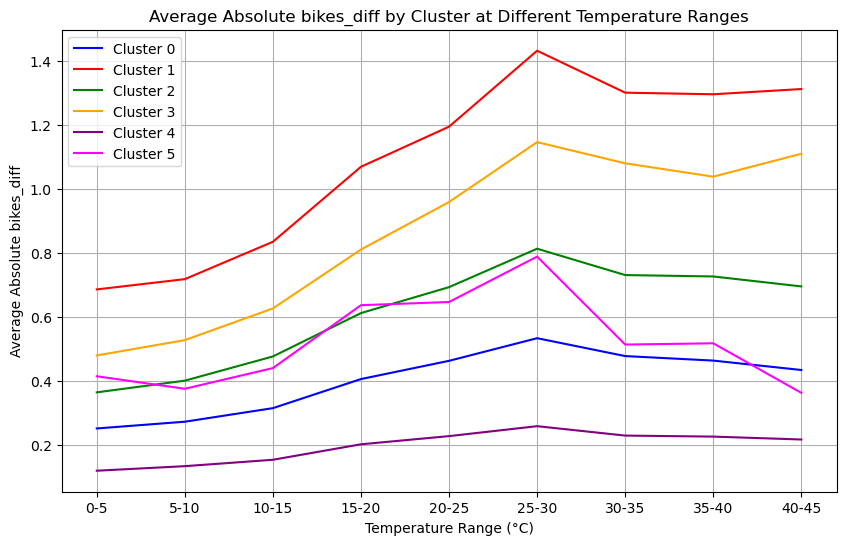

In [28]:
# Group by cluster and temperature bin to calculate average absolute mean of bikes_diff for each cluster
avg_abs_bikes_diff_per_cluster_temp_bin = data.groupby(['cluster', 'temp_bin'])['bikes_diff'].apply(lambda x: np.mean(np.abs(x)))

# Plotting all clusters on the same graph with different colors
plt.figure(figsize=(10, 6))
for cluster in range(k_clusters):
    cluster_data = avg_abs_bikes_diff_per_cluster_temp_bin.loc[cluster]
    plt.plot(cluster_data.index.get_level_values('temp_bin'), cluster_data.values, label=f'Cluster {cluster}', color=cluster_color[cluster])

plt.title('Average Absolute bikes_diff by Cluster at Different Temperature Ranges')
plt.xlabel('Temperature Range (°C)')
plt.ylabel('Average Absolute bikes_diff')
plt.grid(True)
plt.legend()
plt.show()


### Precip

In [29]:
data.w_precip.max()

10.4

/tmp/ipykernel_92090/248120675.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_vacancy_per_cluster_precip_bin = data.groupby(['cluster', 'precip_bin'])['vacancy'].mean()


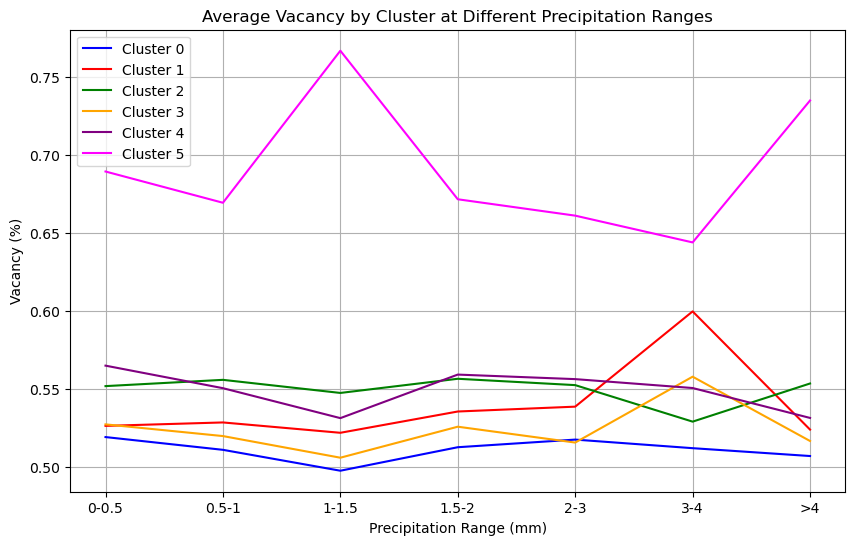

In [30]:
# Define precipitation bins
precip_bins = [0, 0.5, 1, 1.5, 2, 3, 4, 15]
precip_labels = ['0-0.5', '0.5-1', '1-1.5', '1.5-2', '2-3', 
                 '3-4', '>4']

# Bin precipitation data
data['precip_bin'] = pd.cut(data['w_precip'], bins=precip_bins, labels=precip_labels)

# Group by cluster and precipitation bin to calculate average vacancy for each cluster
avg_vacancy_per_cluster_precip_bin = data.groupby(['cluster', 'precip_bin'])['vacancy'].mean()

# Plotting all clusters on the same graph with different colors
plt.figure(figsize=(10, 6))
for cluster in range(k_clusters):
    cluster_data = avg_vacancy_per_cluster_precip_bin.loc[cluster]
    plt.plot(cluster_data.index.get_level_values('precip_bin'), cluster_data.values, label=f'Cluster {cluster}', color=cluster_color[cluster])

plt.title('Average Vacancy by Cluster at Different Precipitation Ranges')
plt.xlabel('Precipitation Range (mm)')
plt.ylabel('Vacancy (%)')
plt.grid(True)
plt.legend()
plt.show()



/tmp/ipykernel_92090/521186941.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_occupancy_per_cluster_precip_bin = data.groupby(['cluster', 'precip_bin'])['occupancy'].mean()


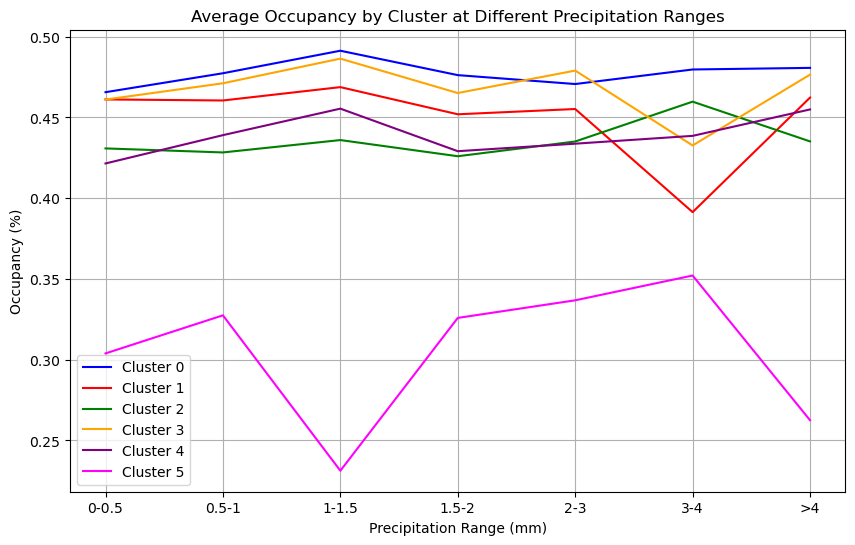

In [31]:
# Group by cluster and precipitation bin to calculate average occupancy for each cluster
avg_occupancy_per_cluster_precip_bin = data.groupby(['cluster', 'precip_bin'])['occupancy'].mean()

# Plotting all clusters on the same graph with different colors
plt.figure(figsize=(10, 6))
for cluster in range(k_clusters):
    cluster_data = avg_occupancy_per_cluster_precip_bin.loc[cluster]
    plt.plot(cluster_data.index.get_level_values('precip_bin'), cluster_data.values, label=f'Cluster {cluster}', color=cluster_color[cluster])

plt.title('Average Occupancy by Cluster at Different Precipitation Ranges')
plt.xlabel('Precipitation Range (mm)')
plt.ylabel('Occupancy (%)')
plt.grid(True)
plt.legend()
plt.show()

/tmp/ipykernel_92090/1097211409.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_abs_bikes_diff_per_cluster_precip_bin = data.groupby(['cluster', 'precip_bin'])['bikes_diff'].apply(lambda x: np.mean(np.abs(x)))


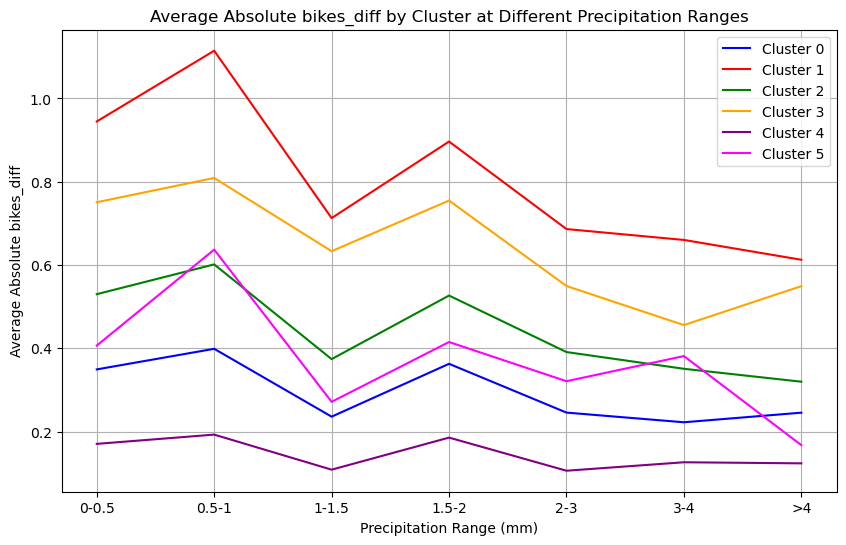

In [32]:
# Group by cluster and precipitation bin to calculate average absolute mean of bikes_diff for each cluster
avg_abs_bikes_diff_per_cluster_precip_bin = data.groupby(['cluster', 'precip_bin'])['bikes_diff'].apply(lambda x: np.mean(np.abs(x)))

# Plotting all clusters on the same graph with different colors
plt.figure(figsize=(10, 6))
for cluster in range(k_clusters):
    cluster_data = avg_abs_bikes_diff_per_cluster_precip_bin.loc[cluster]
    plt.plot(cluster_data.index.get_level_values('precip_bin'), cluster_data.values, label=f'Cluster {cluster}', color=cluster_color[cluster])

plt.title('Average Absolute bikes_diff by Cluster at Different Precipitation Ranges')
plt.xlabel('Precipitation Range (mm)')
plt.ylabel('Average Absolute bikes_diff')
plt.grid(True)
plt.legend()
plt.show()


/tmp/ipykernel_92090/1172693696.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_bikes_diff_per_cluster_precip_bin = data.groupby(['cluster', 'precip_bin'])['bikes_diff'].apply(lambda x: np.mean(x))


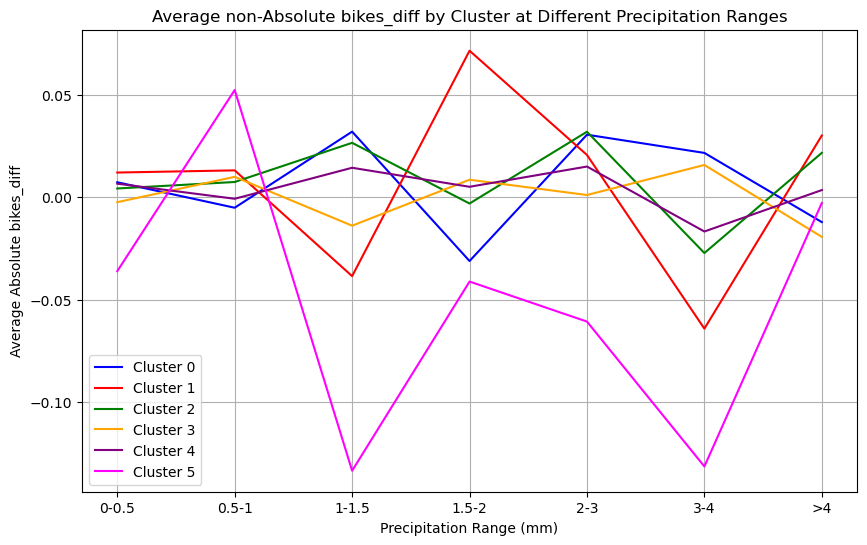

In [33]:
# Group by cluster and precipitation bin to calculate average mean of bikes_diff for each cluster
avg_bikes_diff_per_cluster_precip_bin = data.groupby(['cluster', 'precip_bin'])['bikes_diff'].apply(lambda x: np.mean(x))

# Plotting all clusters on the same graph with different colors
plt.figure(figsize=(10, 6))
for cluster in range(k_clusters):
    cluster_data = avg_bikes_diff_per_cluster_precip_bin.loc[cluster]
    plt.plot(cluster_data.index.get_level_values('precip_bin'), cluster_data.values, label=f'Cluster {cluster}', color=cluster_color[cluster])

plt.title('Average non-Absolute bikes_diff by Cluster at Different Precipitation Ranges')
plt.xlabel('Precipitation Range (mm)')
plt.ylabel('Average Absolute bikes_diff')
plt.grid(True)
plt.legend()
plt.show()


/tmp/ipykernel_92090/3891025852.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_bikes_diff_per_cluster_precip_bin = df_positive_bikes_diff.groupby(['cluster', 'precip_bin'])['bikes_diff'].mean()


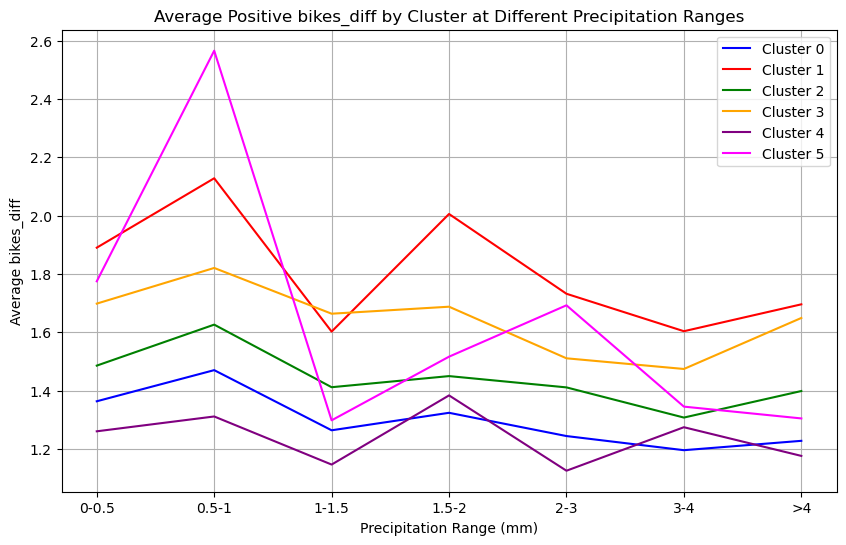

In [34]:
# Filter dataframe to include only positive values of bikes_diff
df_positive_bikes_diff = data[data['bikes_diff'] > 0]

# Group by cluster and precipitation bin to calculate average mean of bikes_diff for each cluster
avg_bikes_diff_per_cluster_precip_bin = df_positive_bikes_diff.groupby(['cluster', 'precip_bin'])['bikes_diff'].mean()

# Plotting all clusters on the same graph with different colors
plt.figure(figsize=(10, 6))
for cluster in range(k_clusters):
    cluster_data = avg_bikes_diff_per_cluster_precip_bin.loc[cluster]
    plt.plot(cluster_data.index.get_level_values('precip_bin'), cluster_data.values, label=f'Cluster {cluster}', color=cluster_color[cluster])

plt.title('Average Positive bikes_diff by Cluster at Different Precipitation Ranges')
plt.xlabel('Precipitation Range (mm)')
plt.ylabel('Average bikes_diff')
plt.grid(True)
plt.legend()
plt.show()


### Sky

In [35]:
print(data["w_sky"].value_counts())

w_sky
Despejado                                                 3678799
Soleado                                                   3633540
Parcialmente nublado                                      1721688
Cielo cubierto                                             604440
Nublado                                                    442152
Lluvia moderada a intervalos                               428716
Ligeras precipitaciones                                    153456
Cielos tormentosos en las aproximaciones                    81420
Llovizna                                                    65964
Ligeras lluvias                                             23736
Llovizna a intervalos                                       14352
Intervalos de lluvias ligeras con tomenta en la región      12144
Lluvias fuertes o moderadas                                 12144
Periodos de lluvia moderada                                  7728
Lluvia moderada                                              5520
Lluv

#### Change the values into fewer categories
In order to visualize the data better, we needed to remap sky values into fewer categories, we did it this way:

**sun**:
* Despejado
* Soleado
* Parcialmente nublado

**clouds**:
* Cielo cubierto
* Nublado
* Neblina

**rain**:
* Lluvia moderada a intervalos
* Ligeras precipitaciones
* Llovizna, Ligeras lluvias
* Llovizna a intervalos
* Periodos de lluvia moderada
* Lluvia moderada
* Lluvias ligeras a intervalos
* Periodos de fuertes lluvias

**storm**: 
* Cielos tormentosos en las aproximaciones
* Intervalos de lluvias ligeras con tomenta en la región
* Lluvias fuertes o moderadas, Fuertes lluvias

In [36]:
sky_mapping = {
    'Despejado': 'sun', 
    'Soleado': 'sun', 
    'Parcialmente nublado': 'sun',
    
    'Cielo cubierto': 'clouds', 
    'Nublado': 'clouds',
    'Neblina':'clouds',
    
    'Lluvia moderada a intervalos': 'rain', 
    'Ligeras precipitaciones': 'rain', 
    'Llovizna': 'rain', 
    'Ligeras lluvias': 'rain', 
    'Llovizna a intervalos': 'rain',
    'Periodos de lluvia moderada':'rain',
    'Lluvia moderada':'rain',
    'Lluvias ligeras a intervalos':'rain',
    'Periodos de fuertes lluvias':'rain',
    
    'Cielos tormentosos en las aproximaciones': 'storm', 
    'Intervalos de lluvias ligeras con tomenta en la región': 'storm', 
    'Lluvias fuertes o moderadas': 'storm', 
    'Fuertes lluvias': 'storm'
}

# Replace values in the 'sky' column using mapping dictionary
data['w_sky'] = data['w_sky'].replace(sky_mapping)

data["w_sky"].value_counts()

w_sky
sun       9034027
clouds    1047696
rain       702784
storm      106812
Name: count, dtype: int64

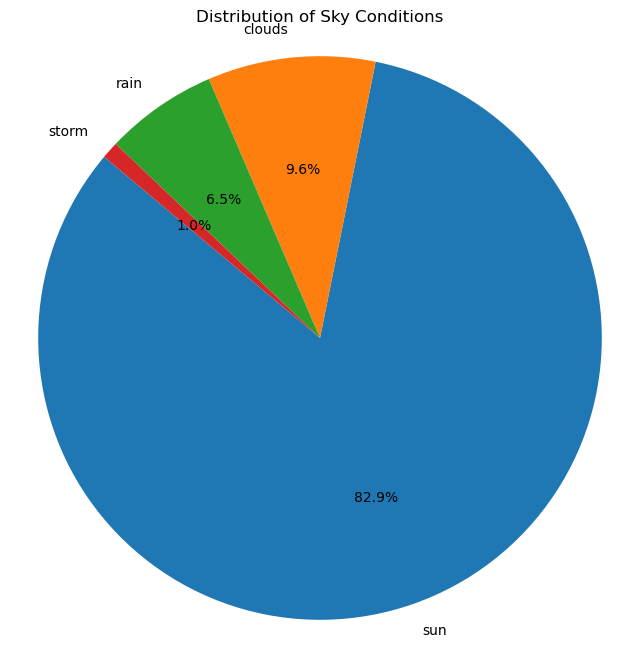

In [37]:
sky_counts = data['w_sky'].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(sky_counts, labels=sky_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Sky Conditions')
plt.axis('equal')
plt.show()

#### Plot the dependencies

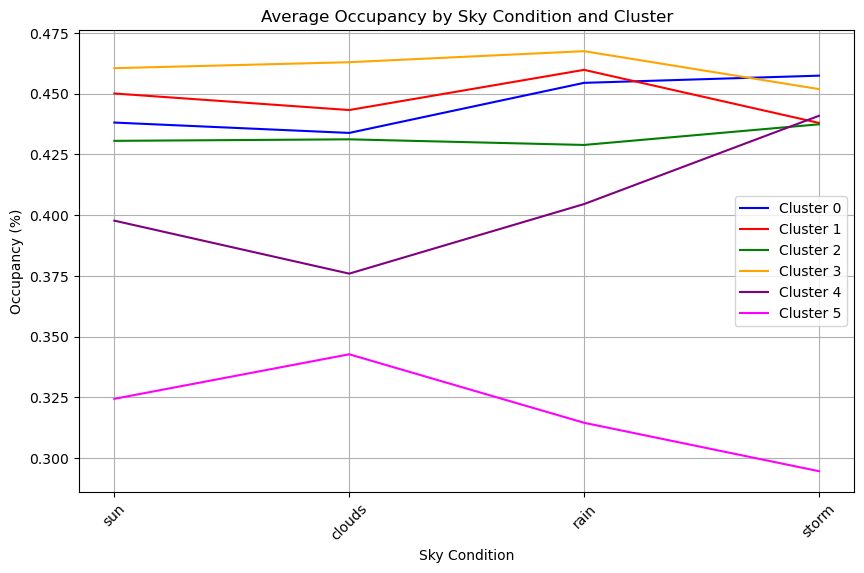

In [38]:
# Define the order of sky conditions
sky_order = ['sun', 'clouds', 'rain', 'storm']

# Grouping by cluster and sky to calculate average occupancy for each combination
avg_occupancy_per_cluster_sky = data.groupby(['cluster', 'w_sky'])['occupancy'].mean()

# Plotting all clusters on the same graph with different colors
plt.figure(figsize=(10, 6))
for cluster in range(k_clusters):  # assuming you have defined k_clusters previously
    cluster_data = avg_occupancy_per_cluster_sky.loc[cluster]
    # Reorder the data based on the specified sky order
    cluster_data_sorted = cluster_data.reindex(sky_order)
    plt.plot(cluster_data_sorted.index, cluster_data_sorted.values, label=f'Cluster {cluster}', color=cluster_color[cluster])

plt.title('Average Occupancy by Sky Condition and Cluster')
plt.xlabel('Sky Condition')
plt.ylabel('Occupancy (%)')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()


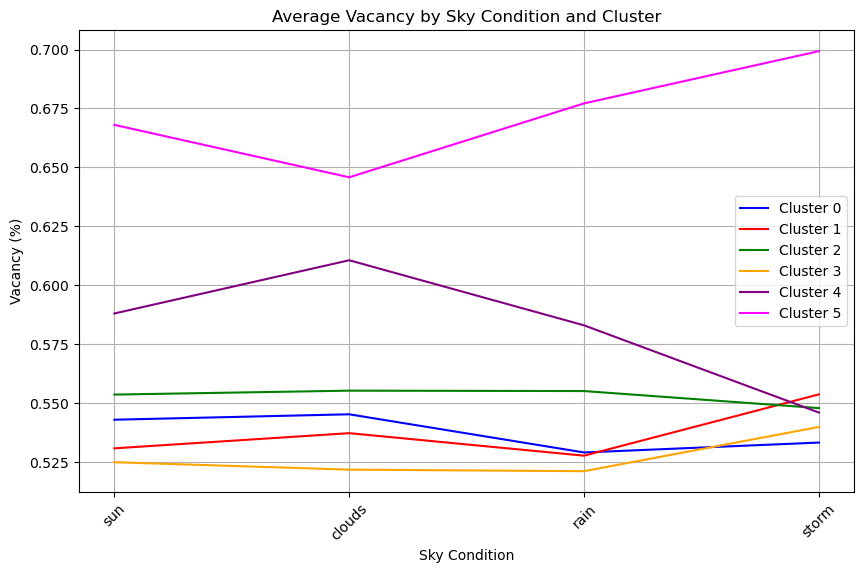

In [39]:
# Define the order of sky conditions
sky_order = ['sun', 'clouds', 'rain', 'storm']

# Grouping by cluster and sky to calculate average vacancy for each combination
avg_vacancy_per_cluster_sky = data.groupby(['cluster', 'w_sky'])['vacancy'].mean()

# Plotting all clusters on the same graph with different colors
plt.figure(figsize=(10, 6))
for cluster in range(k_clusters):  # assuming you have defined k_clusters previously
    cluster_data = avg_vacancy_per_cluster_sky.loc[cluster]
    # Reorder the data based on the specified sky order
    cluster_data_sorted = cluster_data.reindex(sky_order)
    plt.plot(cluster_data_sorted.index, cluster_data_sorted.values, label=f'Cluster {cluster}', color=cluster_color[cluster])

plt.title('Average Vacancy by Sky Condition and Cluster')
plt.xlabel('Sky Condition')
plt.ylabel('Vacancy (%)')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()


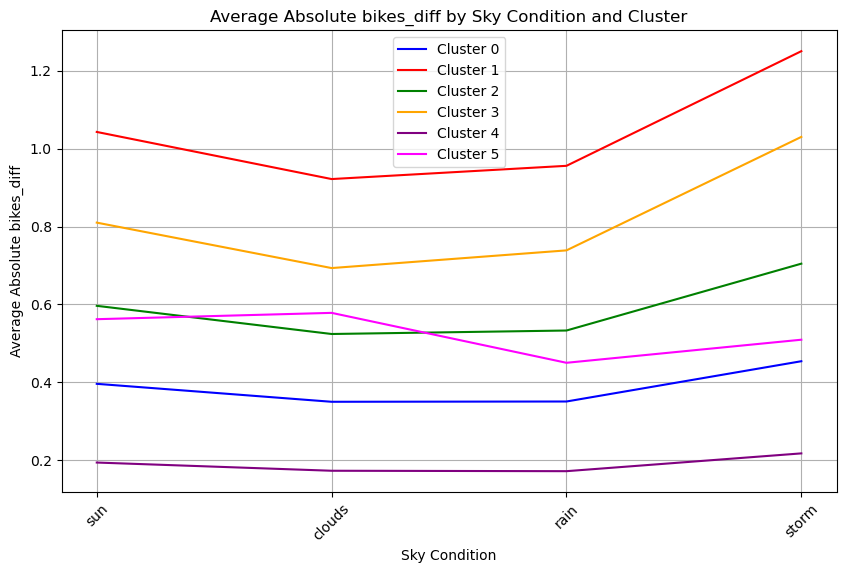

In [40]:
# Grouping by cluster and sky to calculate average absolute mean of bikes_diff for each combination
avg_abs_bikes_diff_per_cluster_sky = data.groupby(['cluster', 'w_sky'])['bikes_diff'].apply(lambda x: np.mean(np.abs(x)))

# Plotting all clusters on the same graph with different colors
plt.figure(figsize=(10, 6))
for cluster in range(k_clusters):  # assuming you have defined k_clusters previously
    cluster_data = avg_abs_bikes_diff_per_cluster_sky.loc[cluster]
    # Reorder the data based on the specified sky order
    cluster_data_sorted = cluster_data.reindex(sky_order)
    plt.plot(cluster_data_sorted.index, cluster_data_sorted.values, label=f'Cluster {cluster}', color=cluster_color[cluster])

plt.title('Average Absolute bikes_diff by Sky Condition and Cluster')
plt.xlabel('Sky Condition')
plt.ylabel('Average Absolute bikes_diff')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()


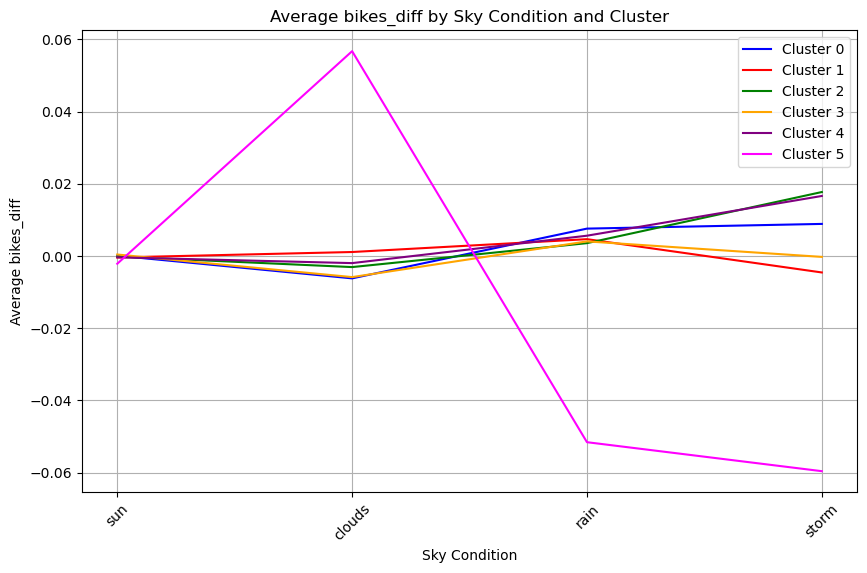

In [41]:
# Grouping by cluster and sky to calculate average bikes_diff for each combination
avg_bikes_diff_per_cluster_sky = data.groupby(['cluster', 'w_sky'])['bikes_diff'].mean()

# Plotting all clusters on the same graph with different colors
plt.figure(figsize=(10, 6))
for cluster in range(k_clusters):  # assuming you have defined k_clusters previously
    cluster_data = avg_bikes_diff_per_cluster_sky.loc[cluster]
    # Reorder the data based on the specified sky order
    cluster_data_sorted = cluster_data.reindex(sky_order)
    plt.plot(cluster_data_sorted.index, cluster_data_sorted.values, label=f'Cluster {cluster}', color=cluster_color[cluster])

plt.title('Average bikes_diff by Sky Condition and Cluster')
plt.xlabel('Sky Condition')
plt.ylabel('Average bikes_diff')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()


## Festivities

In the end we are going to find out the relationships between weather conditions and what type of day it is. We are checking if it is a working day or not. If the day is not working day we will analyse the differences between holidays and weekends.

In [42]:
data.head()

,gid,available,free,total,w_temp,w_sky,w_precip,w_humid,w_wind_speed,w_clouds,...,lat,long,datetime,occupancy,vacancy,bikes_diff,free_diff,cluster,temp_bin,precip_bin
0,901622,18,2,20,12.0,clouds,0.0,66.0,6.8,88.0,...,39.458781,-0.358658,2022-12-01 02:00:00,0.900000,0.100000,0.0,0.0,3,10-15,NaN
1,901673,9,29,38,12.0,clouds,0.0,66.0,6.8,88.0,...,39.472282,-0.343809,2022-12-01 02:00:00,0.236842,0.763158,0.0,0.0,1,10-15,NaN
2,901677,15,8,23,12.0,clouds,0.0,66.0,6.8,88.0,...,39.473068,-0.343132,2022-12-01 02:00:00,0.652174,0.347826,0.0,0.0,3,10-15,NaN
3,901679,3,18,21,12.0,clouds,0.0,66.0,6.8,88.0,...,39.471344,-0.340484,2022-12-01 02:00:00,0.142857,0.857143,0.0,0.0,3,10-15,NaN
4,901627,15,4,20,12.0,clouds,0.0,66.0,6.8,88.0,...,39.456512,-0.355418,2022-12-01 02:00:00,0.750000,0.200000,0.0,0.0,3,10-15,NaN


In [43]:
data['dayofweek'].value_counts()

dayofweek
Thursday     1655448
Tuesday      1605950
Friday       1592796
Saturday     1581292
Wednesday    1574028
Sunday       1567680
Monday       1314125
Name: count, dtype: int64

In [44]:
data['day_category'].value_counts()

day_category
Working day       7346287
Weekend           3096256
Public holiday     448776
Name: count, dtype: int64

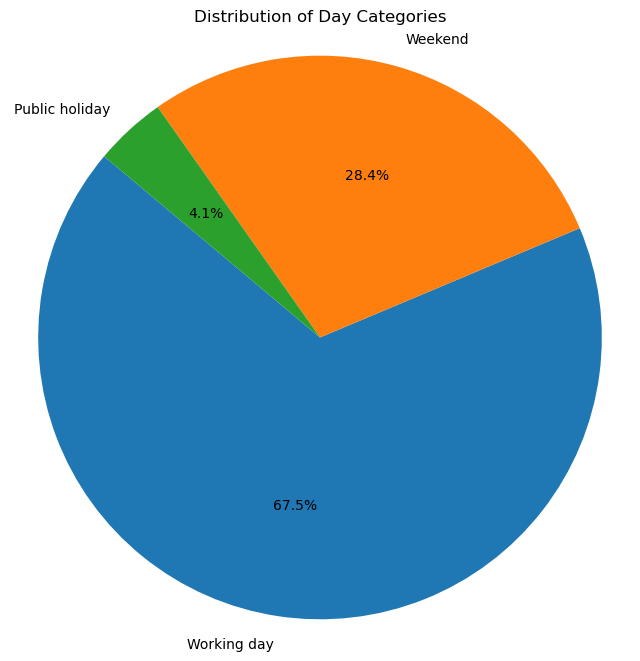

In [45]:
day_category_counts = data['day_category'].value_counts()

# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(day_category_counts, labels=day_category_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Day Categories')
plt.axis('equal') 
plt.show()

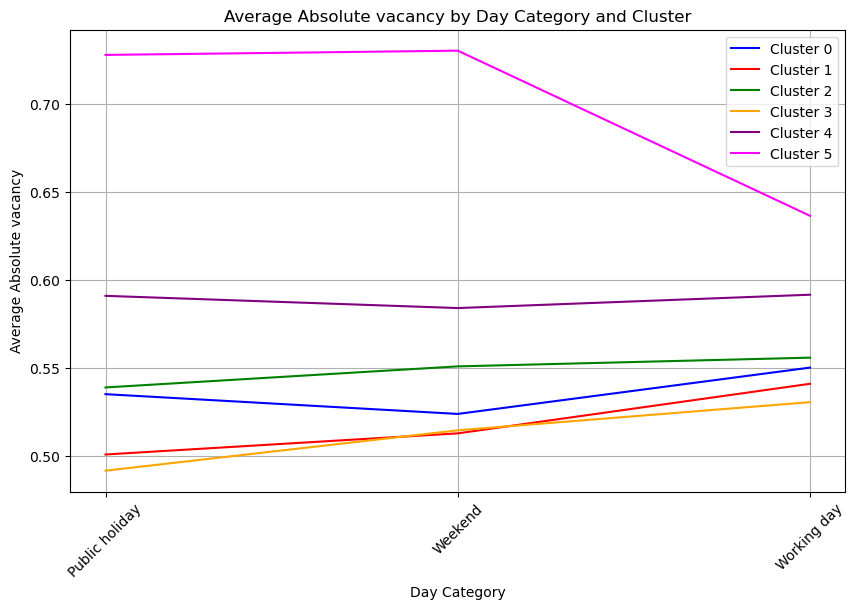

In [46]:
# Grouping by cluster and day_category to calculate mean of vacancy for each combination
avg_vacancy_per_cluster_day_category = data.groupby(['cluster', 'day_category'])['vacancy'].mean()

# Plotting all clusters on the same graph with different colors
plt.figure(figsize=(10, 6))
for cluster in range(k_clusters):  # assuming you have defined k_clusters previously
    cluster_data = avg_vacancy_per_cluster_day_category.loc[cluster]
    plt.plot(cluster_data.index, cluster_data.values, label=f'Cluster {cluster}', color=cluster_color[cluster])

plt.title('Average Absolute vacancy by Day Category and Cluster')
plt.xlabel('Day Category')
plt.ylabel('Average Absolute vacancy')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

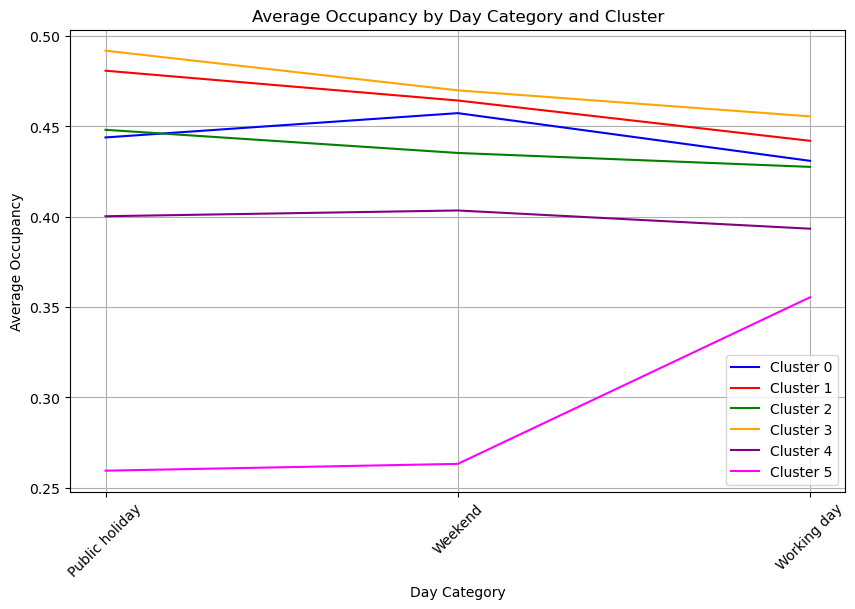

In [47]:
# Grouping by cluster and day_category to calculate average mean of occupancy for each combination
avg_occupancy_per_cluster_day_category = data.groupby(['cluster', 'day_category'])['occupancy'].mean()

# Plotting all clusters on the same graph with different colors
plt.figure(figsize=(10, 6))
for cluster in range(k_clusters):  # assuming you have defined k_clusters previously
    cluster_data = avg_occupancy_per_cluster_day_category.loc[cluster]
    plt.plot(cluster_data.index, cluster_data.values, label=f'Cluster {cluster}', color=cluster_color[cluster])

plt.title('Average Occupancy by Day Category and Cluster')
plt.xlabel('Day Category')
plt.ylabel('Average Occupancy')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

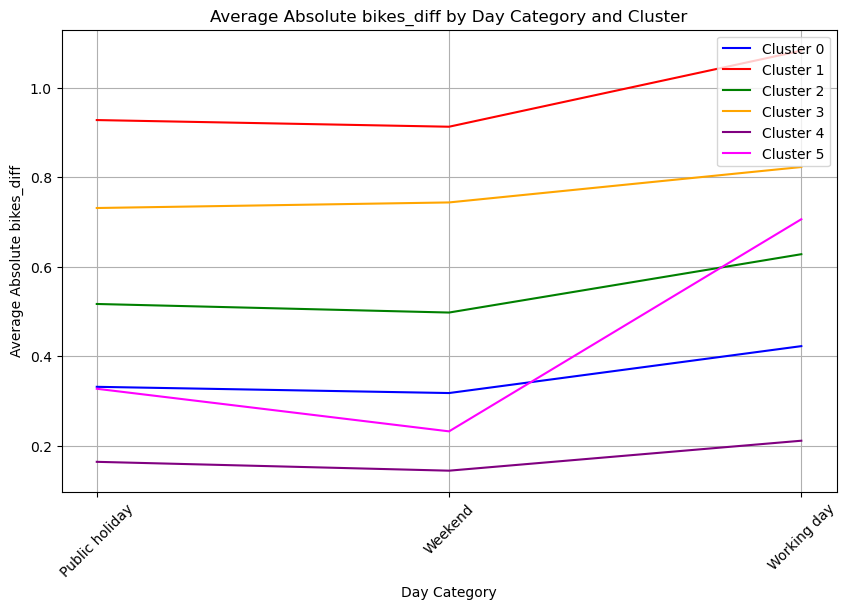

In [48]:
# Grouping by cluster and day_category to calculate average absolute mean of bikes_diff for each combination
avg_abs_bikes_diff_per_cluster_day_category = data.groupby(['cluster', 'day_category'])['bikes_diff'].apply(lambda x: np.mean(np.abs(x)))

# Plotting all clusters on the same graph with different colors
plt.figure(figsize=(10, 6))
for cluster in range(k_clusters):  # assuming you have defined k_clusters previously
    cluster_data = avg_abs_bikes_diff_per_cluster_day_category.loc[cluster]
    plt.plot(cluster_data.index, cluster_data.values, label=f'Cluster {cluster}', color=cluster_color[cluster])

plt.title('Average Absolute bikes_diff by Day Category and Cluster')
plt.xlabel('Day Category')
plt.ylabel('Average Absolute bikes_diff')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

In [49]:
data['day_motive'].value_counts()

day_motive
Sunday                             1567680
Saturday                           1528576
Día de la Constitución               52992
Día de la Inmaculada Concepción      52992
Epifanía del Señor                   52440
Lunes de Pascua                      26496
San Vicente Mártir (trasladada)      26496
Fiesta del trabajo                   26496
San Juan                             26496
Asunción de la Virgen                26496
Fiesta Nacional de España            26496
Todos los Santos                     26496
Natividad del Señor                  26496
Año Nuevo                            26496
Viernes Santo                        25944
San Vicente Ferrer                   25944
Name: count, dtype: int64

In [50]:
data['day_motive'] = data['day_motive'].fillna('working day')

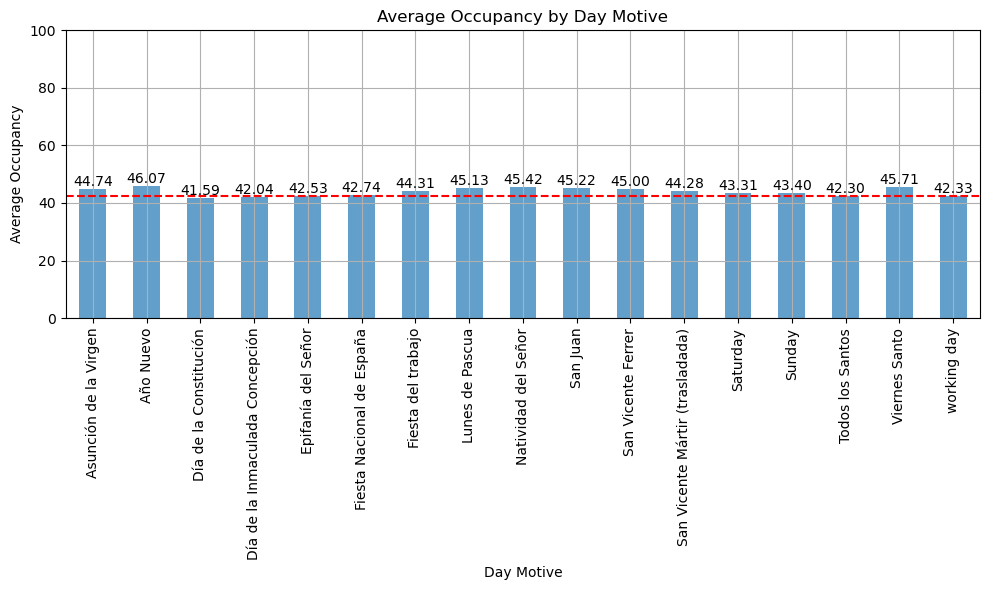

In [51]:
avg_occupancy_day_motive = data.groupby(['day_motive'])['occupancy'].mean() * 100

# Extract indices and values
indices = avg_occupancy_day_motive.index
values = avg_occupancy_day_motive.values

# Plotting all clusters on the same graph with different colors
plt.figure(figsize=(10, 6))

bar_plot = avg_occupancy_day_motive.plot(kind='bar', alpha=0.7)

# Add value labels on each bar
for i in range(len(indices)):
    plt.text(i, values[i], f'{values[i]:.2f}', ha='center', va='bottom')

# Add a red horizontal line for 'working day'
working_day_value = values[indices.get_loc('working day')]
plt.axhline(y=working_day_value, color='red', linestyle='--', label='Working Day')

plt.title('Average Occupancy by Day Motive')
plt.xlabel('Day Motive')
plt.ylabel('Average Occupancy')
plt.ylim(0, 100)  # Set y-axis limits
plt.grid(True)
plt.tight_layout()
plt.show()


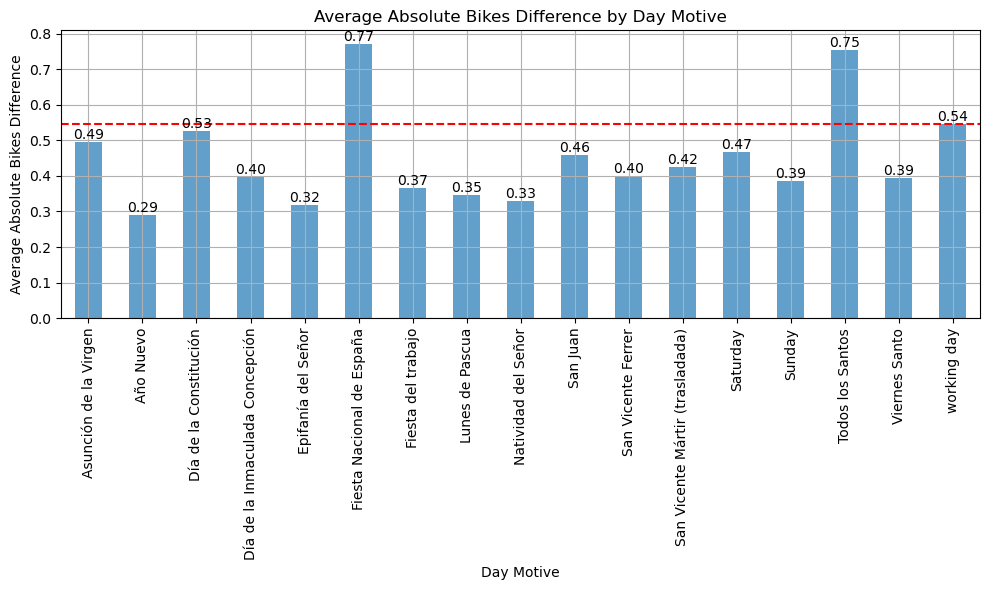

In [52]:
avg_bikes_diff_day_motive = data.groupby(['day_motive'])['bikes_diff'].apply(lambda x: np.mean(np.abs(x)))

# Extract indices and values
indices = avg_bikes_diff_day_motive.index
values = avg_bikes_diff_day_motive.values

# Plotting all clusters on the same graph with different colors
plt.figure(figsize=(10, 6))

bar_plot = avg_bikes_diff_day_motive.plot(kind='bar', alpha=0.7)

# Add value labels on each bar
for i in range(len(indices)):
    plt.text(i, values[i], f'{values[i]:.2f}', ha='center', va='bottom')

# Add a red horizontal line for 'working day'
working_day_value = values[indices.get_loc('working day')]
plt.axhline(y=working_day_value, color='red', linestyle='--', label='Working Day')


plt.title('Average Absolute Bikes Difference by Day Motive')
plt.xlabel('Day Motive')
plt.ylabel('Average Absolute Bikes Difference')
plt.grid(True)
plt.xticks()  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()